In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import dask
from dask_jobqueue import SGECluster
from dask.distributed import Client
import dask.dataframe as dd

# The following can be necessary in some cases
def limit_numpy(nthreads=4):
     """ """
     import os
     threads = str(nthreads)
     print(f"threads {threads}")
     os.environ["NUMEXPR_NUM_THREADS"] = threads
     os.environ["OMP_NUM_THREADS"] = threads
     os.environ["OPENBLAS_NUM_THREADS"] = threads
     os.environ["MKL_NUM_THREADS"] = threads
     os.environ["VECLIB_MAXIMUM_THREADS"] = threads

limit_numpy(4)

threads 4


In [2]:
cluster = SGECluster(name="dask-worker",  walltime="05:00:00", memory='10GB', death_timeout=120, project="P_lsst", 
                     resource_spec='sps=1', cores=1, processes=1, queue="mc_highmem", env_extra=["export MALLOC_TRIM_THRESHOLD_=131072"])
cluster.scale(100)
client = Client(cluster)

In [6]:
client

Client Scheduler: tcp://134.158.48.26:36658 Dashboard: http://134.158.48.26:8787/status,Cluster Workers: 67 Cores: 67 Memory: 623.77 GiB


In [57]:
data_path = "/sps/lsst/groups/desc/skysim5000_v1.1.1_native/skysim5000_v1.1.1_healpix*.parquet"
#data_path = "/sps/lsst/groups/desc/shared/xgal/skysim/skysim5000_v1.1.1_parquet/skysim5000_v1.1.1_healpix*.parquet"

columns = ["ra", "dec", "halo_id", "halo_mass", "redshift", "mag_g", "mag_r", "mag_i", "mag_z", "mag_y", "is_central",
           "convergence", "baseDC2/sod_halo_mass", "baseDC2/is_on_red_sequence_gr", "baseDC2/is_on_red_sequence_ri"]

df = dd.read_parquet(data_path, columns=columns, engine='pyarrow', kwargs={'dataset': {'use_legacy_dataset': False}})

In [58]:
min_halo_mass = 10**13 #Msun

truth_data = df[df.halo_mass>min_halo_mass]
halo_data = df[(df.halo_mass>min_halo_mass) & (df.is_central==True)]
galaxy_data_all = df[(df.halo_mass>min_halo_mass) & (df.mag_i<30)]   

In [59]:
print("Number of elements in the truth catalog = ", len(galaxy_data_all))

Number of elements in the truth catalog =  120889169


In [60]:
print("Number of halos in the truth catalog = ", len(halo_data))

Number of halos in the truth catalog =  5570719


In [11]:
halo_data.head()

,ra,dec,halo_id,halo_mass,redshift,mag_g,mag_r,mag_i,mag_z,mag_y,is_central,convergence,baseDC2/sod_halo_mass,baseDC2/is_on_red_sequence_gr,baseDC2/is_on_red_sequence_ri
177,1.819182,-0.450413,5506080464,1.290993e+13,0.058944,16.966107,16.095616,15.690103,15.424283,15.214057,True,-0.000080,8.044127e+12,True,True
229,2.383940,-0.220196,9406080464,1.937129e+13,0.067805,16.429710,15.567368,15.166042,14.902142,14.701941,True,-0.000152,1.047049e+13,True,True
1517,1.225478,-0.886729,11706080432,1.478354e+13,0.148846,18.006353,16.988222,16.517527,16.238794,16.016903,True,-0.000586,9.500311e+12,True,True
1602,0.495688,-0.409625,18806080432,1.142638e+13,0.134254,18.106377,17.196547,16.800372,16.542525,16.365241,True,0.000690,7.949881e+12,True,True
1662,2.389301,-0.155257,23106080432,1.586087e+13,0.134594,18.223822,17.372300,16.993462,16.721711,16.554072,True,0.000254,8.916359e+12,False,False


In [12]:
galaxy_data_all.head()

,ra,dec,halo_id,halo_mass,redshift,mag_g,mag_r,mag_i,mag_z,mag_y,is_central,convergence,baseDC2/sod_halo_mass,baseDC2/is_on_red_sequence_gr,baseDC2/is_on_red_sequence_ri
177,1.819182,-0.450413,5506080464,1.290993e+13,0.058944,16.966107,16.095616,15.690103,15.424283,15.214057,True,-0.000080,8.044127e+12,True,True
178,1.858688,-0.390812,5506080464,1.290993e+13,0.060835,21.785960,21.377345,21.124830,20.989822,20.903354,False,-0.000014,8.044127e+12,False,False
179,1.844373,-0.463940,5506080464,1.290993e+13,0.059392,17.831878,16.985828,16.540311,16.156551,15.960591,False,-0.000195,8.044127e+12,True,True
180,1.786733,-0.418667,5506080464,1.290993e+13,0.059590,20.417810,19.703201,19.257644,18.908508,18.715938,False,0.000243,8.044127e+12,False,False
181,1.814883,-0.470912,5506080464,1.290993e+13,0.060243,21.280379,20.570048,20.177962,19.859733,19.682847,False,-0.000030,8.044127e+12,False,False


In [13]:
galaxy_data_all.redshift

Dask Series Structure:
npartitions=251
    float64
        ...
     ...   
        ...
        ...
Name: redshift, dtype: float64
Dask Name: getitem, 2008 tasks

In [61]:
def mstar_i(redshift):
    bin = (redshift-0.020).round(2)/0.010
    bin = bin.round()+1
    bin = bin.mask(bin > 248, 248)
    return bin

def mstar_z(redshift):
    bin = redshift.round(2)/0.05
    bin = bin.round()
    bin = bin.mask(bin>55, 55)
    return bin

In [62]:
galaxy_data_all['index_i']=mstar_i(galaxy_data_all.redshift)
galaxy_data_all['index_z']=mstar_z(galaxy_data_all.redshift)

In [15]:
galaxy_data_all.head()

,ra,dec,halo_id,halo_mass,redshift,mag_g,mag_r,mag_i,mag_z,mag_y,is_central,convergence,baseDC2/sod_halo_mass,baseDC2/is_on_red_sequence_gr,baseDC2/is_on_red_sequence_ri,index_i,index_z
177,1.819182,-0.450413,5506080464,1.290993e+13,0.058944,16.966107,16.095616,15.690103,15.424283,15.214057,True,-0.000080,8.044127e+12,True,True,5.0,1.0
178,1.858688,-0.390812,5506080464,1.290993e+13,0.060835,21.785960,21.377345,21.124830,20.989822,20.903354,False,-0.000014,8.044127e+12,False,False,5.0,1.0
179,1.844373,-0.463940,5506080464,1.290993e+13,0.059392,17.831878,16.985828,16.540311,16.156551,15.960591,False,-0.000195,8.044127e+12,True,True,5.0,1.0
180,1.786733,-0.418667,5506080464,1.290993e+13,0.059590,20.417810,19.703201,19.257644,18.908508,18.715938,False,0.000243,8.044127e+12,False,False,5.0,1.0
181,1.814883,-0.470912,5506080464,1.290993e+13,0.060243,21.280379,20.570048,20.177962,19.859733,19.682847,False,-0.000030,8.044127e+12,False,False,5.0,1.0


In [63]:
from astropy.io import ascii
from astropy.modeling import models, fitting

d_i = ascii.read("istar.asc")
d_z = ascii.read("zstar.asc")

poly_i = models.Polynomial1D(degree=7)
poly_z = models.Polynomial1D(degree=7)
fit = fitting.LevMarLSQFitter()

mag_star_i = fit(poly_i, d_i["col1"][1::], d_i["col2"][1::])
mag_star_z = fit(poly_z, d_z["col1"][1::], d_z["col2"][1::])

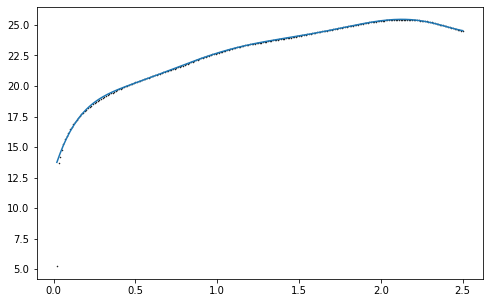

In [64]:
plt.figure(figsize=(8,5))
plt.plot(d_i["col1"], d_i["col2"], 'ko', markersize=0.5)
plt.plot(d_i["col1"], mag_star_i(d_i["col1"]))

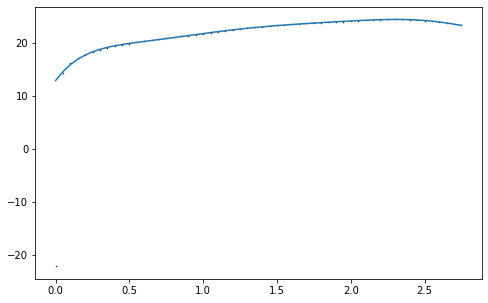

In [65]:
plt.figure(figsize=(8,5))
plt.plot(d_z["col1"], d_z["col2"], 'ko', markersize=0.5)
plt.plot(d_z["col1"], mag_star_z(d_z["col1"]))

In [66]:
coeff_i = []
coeff_i.append(mag_star_i.c0)
coeff_i.append(mag_star_i.c1)
coeff_i.append(mag_star_i.c2)
coeff_i.append(mag_star_i.c3)
coeff_i.append(mag_star_i.c4)
coeff_i.append(mag_star_i.c5)
coeff_i.append(mag_star_i.c6)
coeff_i.append(mag_star_i.c7)

coeff_z = []
coeff_z.append(mag_star_z.c0)
coeff_z.append(mag_star_z.c1)
coeff_z.append(mag_star_z.c2)
coeff_z.append(mag_star_z.c3)
coeff_z.append(mag_star_z.c4)
coeff_z.append(mag_star_z.c5)
coeff_z.append(mag_star_z.c6)
coeff_z.append(mag_star_z.c7)

In [67]:
def poly_7(x,c):
    return c[0] + c[1]*x + c[2]*x*x +c[3]*x**3 +c[4]*x**4 + c[5]*x**5 + c[6]*x**6 + c[7]*x**7

In [21]:
poly_7(1.5,coeff_z)

23.291313852480464

In [68]:
galaxy_data_all['mstar_i'] = poly_7(galaxy_data_all.redshift, coeff_i)
galaxy_data_all['mstar_z'] = poly_7(galaxy_data_all.redshift, coeff_z)

In [23]:
galaxy_data_all.head()

,ra,dec,halo_id,halo_mass,redshift,mag_g,mag_r,mag_i,mag_z,mag_y,is_central,convergence,baseDC2/sod_halo_mass,baseDC2/is_on_red_sequence_gr,baseDC2/is_on_red_sequence_ri,index_i,index_z,mstar_i,mstar_z
177,1.819182,-0.450413,5506080464,1.290993e+13,0.058944,16.966107,16.095616,15.690103,15.424283,15.214057,True,-0.000080,8.044127e+12,True,True,5.0,1.0,15.118570,14.883607
178,1.858688,-0.390812,5506080464,1.290993e+13,0.060835,21.785960,21.377345,21.124830,20.989822,20.903354,False,-0.000014,8.044127e+12,False,False,5.0,1.0,15.177302,14.937042
179,1.844373,-0.463940,5506080464,1.290993e+13,0.059392,17.831878,16.985828,16.540311,16.156551,15.960591,False,-0.000195,8.044127e+12,True,True,5.0,1.0,15.132536,14.896305
180,1.786733,-0.418667,5506080464,1.290993e+13,0.059590,20.417810,19.703201,19.257644,18.908508,18.715938,False,0.000243,8.044127e+12,False,False,5.0,1.0,15.138705,14.901915
181,1.814883,-0.470912,5506080464,1.290993e+13,0.060243,21.280379,20.570048,20.177962,19.859733,19.682847,False,-0.000030,8.044127e+12,False,False,5.0,1.0,15.158958,14.920342


In [69]:
select_i = (galaxy_data_all.mag_i < galaxy_data_all.mstar_i + 2) & (galaxy_data_all.mag_i < 25.47)
select_z = (galaxy_data_all.mag_z < galaxy_data_all.mstar_z + 2) & (galaxy_data_all.mag_z < 24.46)

In [70]:
galaxy_data_i = galaxy_data_all[select_i]
galaxy_data_z = galaxy_data_all[select_z] 

In [38]:
galaxy_data_i.head()

,ra,dec,halo_id,halo_mass,redshift,mag_g,mag_r,mag_i,mag_z,mag_y,is_central,convergence,baseDC2/sod_halo_mass,baseDC2/is_on_red_sequence_gr,baseDC2/is_on_red_sequence_ri,index_i,index_z,mstar_i,mstar_z
177,1.819182,-0.450413,5506080464,1.290993e+13,0.058944,16.966107,16.095616,15.690103,15.424283,15.214057,True,-0.000080,8.044127e+12,True,True,5.0,1.0,15.118570,14.883607
179,1.844373,-0.463940,5506080464,1.290993e+13,0.059392,17.831878,16.985828,16.540311,16.156551,15.960591,False,-0.000195,8.044127e+12,True,True,5.0,1.0,15.132536,14.896305
182,1.816308,-0.457324,5506080464,1.290993e+13,0.058965,16.523142,15.859202,15.504176,15.255572,15.071066,False,-0.000176,8.044127e+12,True,False,5.0,1.0,15.119219,14.884197
229,2.383940,-0.220196,9406080464,1.937129e+13,0.067805,16.429710,15.567368,15.166042,14.902142,14.701941,True,-0.000152,1.047049e+13,True,True,6.0,1.0,15.388155,15.129701
231,2.431140,-0.268609,9406080464,1.937129e+13,0.067523,16.723084,15.934668,15.549368,15.304569,15.123653,False,-0.000186,1.047049e+13,False,False,6.0,1.0,15.379793,15.122035


In [39]:
len(galaxy_data_i)

5005097

In [71]:
richness_i = galaxy_data_i.groupby(['halo_id']).size().to_frame(name = 'richness_i').reset_index()
richness_z = galaxy_data_z.groupby(['halo_id']).size().to_frame(name = 'richness_z').reset_index()

In [45]:
richness_i.head()

,halo_id,richness_i
0,106080279,3
1,106080411,1
2,306080315,3
3,406080224,2
4,806080347,30


In [42]:
halo_data.head()

,ra,dec,halo_id,halo_mass,redshift,mag_g,mag_r,mag_i,mag_z,mag_y,is_central,convergence,baseDC2/sod_halo_mass,baseDC2/is_on_red_sequence_gr,baseDC2/is_on_red_sequence_ri
177,1.819182,-0.450413,5506080464,1.290993e+13,0.058944,16.966107,16.095616,15.690103,15.424283,15.214057,True,-0.000080,8.044127e+12,True,True
229,2.383940,-0.220196,9406080464,1.937129e+13,0.067805,16.429710,15.567368,15.166042,14.902142,14.701941,True,-0.000152,1.047049e+13,True,True
1517,1.225478,-0.886729,11706080432,1.478354e+13,0.148846,18.006353,16.988222,16.517527,16.238794,16.016903,True,-0.000586,9.500311e+12,True,True
1602,0.495688,-0.409625,18806080432,1.142638e+13,0.134254,18.106377,17.196547,16.800372,16.542525,16.365241,True,0.000690,7.949881e+12,True,True
1662,2.389301,-0.155257,23106080432,1.586087e+13,0.134594,18.223822,17.372300,16.993462,16.721711,16.554072,True,0.000254,8.916359e+12,False,False


In [72]:
halo_data = dd.merge(halo_data, richness_i, on='halo_id')
halo_data = dd.merge(halo_data, richness_z, on='halo_id')

In [73]:
%%time
res = halo_data.compute()
res

CPU times: user 3min 14s, sys: 9.8 s, total: 3min 24s
Wall time: 5min 7s


,ra,dec,halo_id,halo_mass,redshift,mag_g,mag_r,mag_i,mag_z,mag_y,is_central,convergence,baseDC2/sod_halo_mass,baseDC2/is_on_red_sequence_gr,baseDC2/is_on_red_sequence_ri,richness_i,richness_z
0,1.819182,-0.450413,5506080464,1.290993e+13,0.058944,16.966107,16.095616,15.690103,15.424283,15.214057,True,-0.000080,8.044127e+12,True,True,3,3
1,2.383940,-0.220196,9406080464,1.937129e+13,0.067805,16.429710,15.567368,15.166042,14.902142,14.701941,True,-0.000152,1.047049e+13,True,True,5,5
2,1.225478,-0.886729,11706080432,1.478354e+13,0.148846,18.006353,16.988222,16.517527,16.238794,16.016903,True,-0.000586,9.500311e+12,True,True,3,3
3,0.495688,-0.409625,18806080432,1.142638e+13,0.134254,18.106377,17.196547,16.800372,16.542525,16.365241,True,0.000690,7.949881e+12,True,True,6,6
4,2.389301,-0.155257,23106080432,1.586087e+13,0.134594,18.223822,17.372300,16.993462,16.721711,16.554072,True,0.000254,8.916359e+12,False,False,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3292,0.117340,-89.462805,1273212284127,1.036957e+13,2.806125,23.642417,23.570499,23.542446,23.600141,23.639331,True,0.046889,8.546769e+12,False,False,1,1
3293,44.099154,-87.714839,1708512284127,1.632146e+13,2.729042,24.313842,24.129063,23.963883,23.966759,23.877772,True,-0.021814,1.305392e+13,False,False,2,1
3294,20.153570,-88.213420,119112284124,1.261067e+13,2.896751,29.279862,27.718960,26.701929,26.294506,26.138962,True,0.031935,9.832943e+12,True,True,1,1
3295,41.920439,-87.467843,3122512284124,2.278023e+13,2.881551,24.749630,24.533382,24.391563,24.365465,24.391296,True,-0.043506,1.613076e+13,False,False,1,1
